In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# python, sklearn등 무슨 버전을 썼는지 작성
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
# python 버전 확인
assert sys.version_info >= (3, 10)

In [8]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

    # 나눔바른고딕 폰트로 설정합니다.
    import matplotlib.pyplot as plt
    plt.rc('font', family='NanumBarunGothic')
    # 마이너스 기호 표시 오류 수정
    import matplotlib
    matplotlib.rcParams['axes.unicode_minus'] = False

### 1.데이터 불러오기

In [9]:
# 학습할 데이터 불러오기

# 1. train_data_modified - 학습 데이터
train = pd.read_csv('/content/drive/MyDrive/지역사회 문제해결형 빅데이터 AI활용 공모전/데이터/train_data_modified.csv')

# 2. Shapefile(nlsp_020001001.shp) - 격자데이터
# shp파일을 불러오기 위해 geopandas 라이브러리를 불러온다.
import geopandas as gpd
gdf = gpd.read_file('/content/drive/MyDrive/지역사회 문제해결형 빅데이터 AI활용 공모전/격자데이터/nlsp_020001001.shp',encoding = 'utf-8')

# 3. 대전광역시_버스정류장 현황 - 외부 데이터(대전광역시 버스 정류장 데이터
bus = pd.read_csv('/content/drive/MyDrive/지역사회 문제해결형 빅데이터 AI활용 공모전/데이터/대전광역시_버스정류장 현황_20221215_v1.csv')

### 2.데이터 가공하기

In [10]:
# gdf 가공하기
# gdf의 columns중에 geometry라는 column이 있는데 이 column은 총인구 격자데이터의 polygon을 가지고 있다. 이러한 polygon을 이용해서 중심이 되는 위경도 값을 구해준다.
# gdf와 같은 데이터를 하나 만든다.
gdf_copy = gdf.copy()

# fiona 라이브러리를 사용해서 위경도를 구해준다. 이 라이브러리는 주로 벡터 데이터를 처리하는데 사용되는 라이브러리이다.
# # to_crs 메서드는 GeoDataFrame의 좌표 체계를 지정한 EPSG 코드로 변환한다. epsg=4326은 변환하고자 하는 좌표 체계를 나타낸다. WGS84 좌표 체계는 일반적으로 위도와 경도를 표현하는 데 사용된다.
# gdf_copy_epsg는 geometry 열의 polygon안의 값을 위경도로 바꾼 데이터이다.
from fiona.crs import from_epsg
gdf_copy_epsg = gdf_copy.to_crs(epsg=4326)
# gdf_copy_epsg.head()

# GeoDataFrame에서 polygon의 center 값을 추출합니다.
center_latitudes = gdf_copy_epsg.geometry.centroid.y
center_longitudes = gdf_copy_epsg.geometry.centroid.x

# 위도와 경도를 gdf_copy_epsg에 추가
gdf_copy_epsg['center_latitudes'] = center_latitudes
gdf_copy_epsg['center_longitudes'] = center_longitudes
# gdf_copy_epsg.head()

<ipython-input-10-69b7770cce9e>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_latitudes = gdf_copy_epsg.geometry.centroid.y
<ipython-input-10-69b7770cce9e>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_longitudes = gdf_copy_epsg.geometry.centroid.x


In [11]:
# train과 gdf_copy_epsg데이터는 모두 gid라는 column을 가진다. 시각화를 위해 두 데이터를  gid column을 기준으로 하나로 합쳐준다.
merged_df = pd.merge(train, gdf_copy_epsg, on='gid', how='inner')
# merged_df.head()

# 이렇게 만들어진 merged_df데이터에서 시각화에 필요없는 데이터를 제거한다
merged_df = merged_df.drop(columns = ['gid','DATE','ALIGHT_DEMAND','lbl','val','geometry'])
# merged_df.head()

# 이렇게 만들어진 merged_df 데이터는 TIME의 변화에 따른 RIDE_DEMAND의 변화를 시각화 하는데 사용된다.

#### 2-1 간단한 데이터 시각화

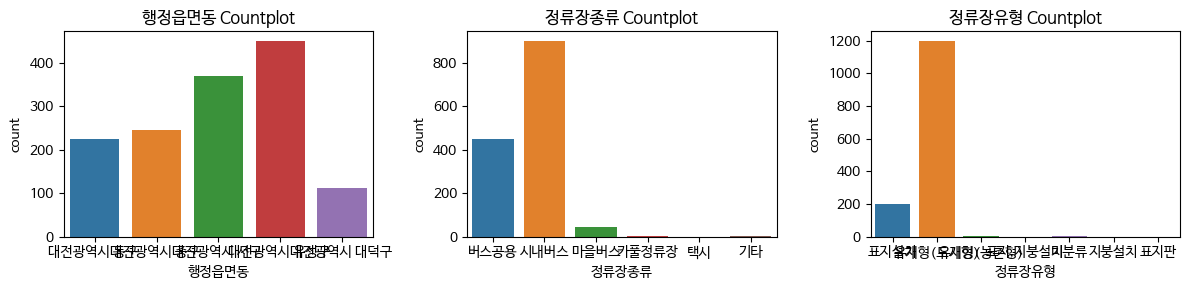

In [12]:
# 버스정류장 데이터를 간단하게 시각화해서 어떠한 변수가 있는지 확인한다.
# 이때 사용되는 데이터는 버스정류장의 정보를 가진 bus 데이터이다.
# Subplot 그리는 함수 생성
def make_subplot_layout(df, col_num):
  k = len(df.columns)
  row_num = math.ceil(k / col_num)
  plt.figure(figsize = (col_num * 4, row_num * 3))
  for i in range(k):
    plt.subplot(row_num, col_num, i + 1)
    sns.countplot(data = df, x = df.iloc[:, i])
    plt.title('{} Countplot'.format(df.iloc[:, i].name))
  plt.tight_layout()
  plt.show()

# 시각화에 필요한 범주형 데이터를 리스트로 만들어서 새로운 데이터로 만든다.
EDA_list = ['행정읍면동','정류장종류','정류장유형']
bus_eda = bus[EDA_list]
bus_eda.shape

# 범주형 변수 컬럼의 분포를 확인한다.
make_subplot_layout(bus_eda, 3)

### 3.대전광역시 총인구 분포 시각화하기
> 1. 분포만 시각화 하기

> 2. 버스 정류장 시각화 하기-클러스터

> 3. 총 인구 분포와 버스정류장 시각화 하기

In [13]:
# 1. 총인구 분포만 시각화 하기
# 대전광역시의 총인구 분포를 확인하기 위해서 gdf 데이터를 이용해서 대전광역시 총인구의 분포를 구한다.
# 이때 사용된 데이터는 gdf 데이터로 격자데이터이다.
import geopandas as gpd
import folium
from branca.colormap import linear
# Mapbox 액세스 토큰
mapbox_access_token = 'pk.eyJ1IjoiamFtb25nIiwiYSI6ImNsbnJoemJxdDEyN2UyaXBiamcwc2QyNmcifQ.sU2lcRY_NV-rKmYowya8MQ'

# Shapefile 로드
gdf = gpd.read_file('/content/drive/MyDrive/지역사회 문제해결형 빅데이터 AI활용 공모전/격자데이터/nlsp_020001001.shp')

# 중심 좌표 설정
center = [36.3513334, 127.3785388]

# folium 맵 생성
m = folium.Map(location=center, zoom_start=12, tiles=None)

# Mapbox 타일 추가
folium.TileLayer(
    tiles=f'https://api.mapbox.com/styles/v1/mapbox/light-v10/tiles/{{z}}/{{x}}/{{y}}?access_token={mapbox_access_token}',
    attr='Mapbox',
    name='Mapbox Light',
).add_to(m)

# NaN 값 제외한 최솟값 및 최댓값 계산
min_value = gdf['val'].min(skipna=True)
max_value = gdf['val'].max(skipna=True)

# 컬러 맵 생성
colormap = linear.YlGnBu_09.scale(min_value, max_value)

# GeoJSON으로 변환하여 folium에 추가
folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['val']) if feature['properties']['val'] is not None else 'gray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }
).add_to(m)

# 컬러바 추가
colormap.caption = '대전광역시 총인구수'
m.add_child(colormap)

# folium 맵 저장
m

In [14]:
# 2. 클러스터를 이용해서 버스정류정을 지도로 시각화
# 클러스터를 이용해서 버스정류장을 지도 위에 시각화 한다.
# 이때 사용된 데이터는 bus 데이터로 버스정류장의 정보를 가지고 있는 데이터이다.
from folium.plugins import MarkerCluster

# 중심 좌표 계산
center = [36.3513334, 127.3785388]

# Mapbox 액세스 토큰
mapbox_access_token = 'pk.eyJ1IjoiamFtb25nIiwiYSI6ImNsbnJoemJxdDEyN2UyaXBiamcwc2QyNmcifQ.sU2lcRY_NV-rKmYowya8MQ'

# Folium 맵 생성
m = folium.Map(location=center, zoom_start=10, control_scale=True)

# Mapbox 타일 추가
folium.TileLayer(
    tiles=f'https://api.mapbox.com/styles/v1/mapbox/light-v10/tiles/{{z}}/{{x}}/{{y}}?access_token={mapbox_access_token}',
    attr='Mapbox',
    name='Mapbox Light',
).add_to(m)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# 데이터 포인트를 클러스터에 추가
for index, entry in bus.iterrows():
    # 행정읍면동을 문자열로 변경하여 사용
    district = str(entry["행정읍면동"])
    folium.Marker(
        location=[entry["위도"], entry["경도"]],
        popup=district,
        icon=None,  # 마커 아이콘을 None으로 설정하여 클러스터에 추가
    ).add_to(marker_cluster)

m

In [15]:
# 3. 대전광역시 총인구 분포와 버스정류장을 클러스터한 것을 하나의 지도 위에 시각화 한다.
# 이때 사용된 데이터는 앞에서 사용된 train 데이터와 bus 데이터이다.
from folium.plugins import MarkerCluster

# 중심 좌표 계산
center = [36.3513334, 127.3785388]

# Mapbox 액세스 토큰
mapbox_access_token = 'pk.eyJ1IjoiamFtb25nIiwiYSI6ImNsbnJoemJxdDEyN2UyaXBiamcwc2QyNmcifQ.sU2lcRY_NV-rKmYowya8MQ'

# Folium 맵 생성
m = folium.Map(location=center, zoom_start=10, control_scale=True)

# Mapbox 타일 추가
folium.TileLayer(
    tiles=f'https://api.mapbox.com/styles/v1/mapbox/light-v10/tiles/{{z}}/{{x}}/{{y}}?access_token={mapbox_access_token}',
    attr='Mapbox',
    name='Mapbox Light',
).add_to(m)

# Shapefile 로드
gdf = gpd.read_file('/content/drive/MyDrive/지역사회 문제해결형 빅데이터 AI활용 공모전/격자데이터/nlsp_020001001.shp')

# NaN 값 제외한 최솟값 및 최댓값 계산
min_value = gdf['val'].min(skipna=True)
max_value = gdf['val'].max(skipna=True)

# 컬러 맵 생성
colormap = linear.YlGnBu_09.scale(min_value, max_value)

# GeoJSON으로 변환하여 folium에 추가
folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['val']) if feature['properties']['val'] is not None else 'gray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }
).add_to(m)

colormap.caption = '대전광역시 총인구수'
m.add_child(colormap)

# MarkerCluster 생성
marker_cluster = MarkerCluster().add_to(m)

# 데이터 포인트를 클러스터에 추가
for index, entry in bus.iterrows():
    # 행정읍면동을 문자열로 변경하여 사용
    district = str(entry["행정읍면동"])
    folium.Marker(
        location=[entry["위도"], entry["경도"]],
        popup=district,
        icon=None,  # 마커 아이콘을 None으로 설정하여 클러스터에 추가
    ).add_to(marker_cluster)

m

In [16]:
### 위의 결과를 보면 인구 분포가 많은 곳 일수록 버스정류장의 분포가 많은 것을 볼 수 있다.

### 4.TIME의 변화에 따른 RIDE_DEMAND 변화 시각화 하기

#### 4-1 간단한 시각화

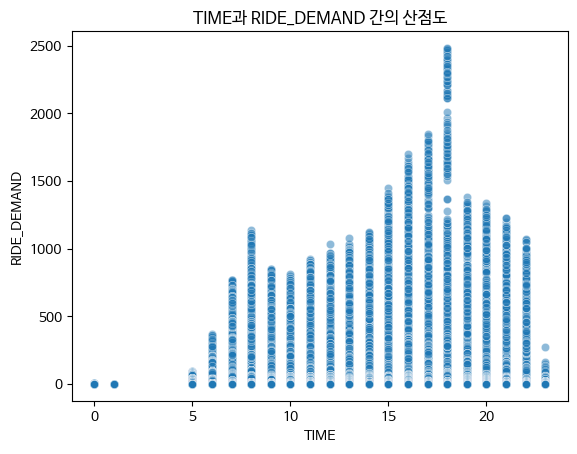

In [17]:
# TIME의 변화에 따른 RIDE_DEMAND의 변화를 지도 위에 시각화 하기 위해 우선 TIME과 RIDE_DEMAND에 관한 그래프를 산점도로 나타낸다.
# 'RIDE_DEMAND'와 다른 변수들 간의 상관관계를 산점도로 표시
# 이때 사용한 데이터는 train 데이터이다.
sns.scatterplot(data=train, x='TIME', y='RIDE_DEMAND', alpha=0.5)  # alpha로 투명도 설정
plt.title('TIME과 RIDE_DEMAND 간의 산점도')
plt.show()

In [18]:
# 위의 결과를 보면 17 ~ 18시에 사람이 가장 많이 승차하는 것을 볼 수 있다.

#### 4-2 TIME의 변화에 따른 RIDE_DEMAND 변화 지도 위에 시각화 하기

In [19]:
# TIME의 변화에 따른 RIDE_DEMAND 변화 지도 위에 시각화 한다. 이때 애니메이션을 사용해서 시간의 변화에 따른 RIDE_DEMAND의 변화를 볼 수 있게 한다.
# 이때 사용되는 데이터는 앞에서 train과 gdf의 polygon을 위경도로 바꾼 gdf_copy_epsg 데이터를 하나로 합친 merged_df 데이터를 사용한다.
import plotly.express as px

# 데이터프레임의 크기 값 스케일링
size_min = 20
size_max = 50
min_size_value = merged_df['RIDE_DEMAND'].min()
max_size_value = merged_df['RIDE_DEMAND'].max()

scaled_sizes = (merged_df['RIDE_DEMAND'] - min_size_value) / (max_size_value - min_size_value)
scaled_sizes = size_min + scaled_sizes * (size_max - size_min)

# Plotly Express를 사용하여 애니메이션 지도 생성
fig = px.scatter_mapbox(merged_df,
                        lat='center_latitudes',
                        lon='center_longitudes',
                        color='RIDE_DEMAND',
                        size=scaled_sizes,
                        animation_frame='TIME',
                        title='RIDE_DEMAND Animation',
                        labels={'RIDE_DEMAND': 'RIDE_DEMAND'},
                        mapbox_style='carto-positron',  # Mapbox 스타일 지정
                        zoom=10,  # 초기 줌 레벨
                        center=dict(lat=36.3513334, lon=127.3785388))  # 초기 중심 좌표

# 레이아웃 업데이트: width와 height 속성을 조절하여 크기 조절
fig.update_layout(width=1000, height=800)

# 애니메이션을 보여줍니다.
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# 위의 결과는 날짜와 상관 없이 TIME의 변화에 따른 RIDE_DEMAND의 변화를 애니메이션 한 것이다. 지도 위에 있는 점들은 격자데이터의 polygon을 위경도로 바꾸어서 지도 위에 나타낸 것이다.